In [36]:
# Imports
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.models as models
import os
import torch
from pathlib import Path
from torch import nn
from torchvision import transforms
from torchinfo import summary
import data_setup
import engine_LRoptim
from helper_functions import plot_save_loss_curves
from padfunc import CustomResizeAndReflectPad
from torchvision.transforms import ToTensor, Normalize, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, Grayscale
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from datetime import datetime
import json
import pandas as pd
from PIL import Image
import numpy as np
import skimage

# Set data paths
base_dir = Path("C:/Data/Python/IFCBclassify_MN/")
data_path = Path("C:\Data\Python\IFCB\data")
image_path = Path("C:\Data\Python\IFCB\data\IFCB_test_train")


# # Setup Dirs
# train_dir = image_path / "Train_small"
# test_dir = image_path / "Test_small"
# val_dir = image_path / "Val_small"
# Setup Dirs
# train_dir = image_path / "Train_med"
# test_dir = image_path / "Test_med"
# val_dir = image_path / "Val_med"
# Setup Dirs
train_dir = image_path / "Train"
test_dir = image_path / "Test"
val_dir = image_path / "Val"


# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
#print(device)


In [37]:
# Create transforms pipeline
    
train_transform = transforms.Compose([
    CustomResizeAndReflectPad(),  # Apply custom resize, reflect pad, and mirror
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=[0.95, 1.1]),    
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

simple_transform = transforms.Compose([
    CustomResizeAndReflectPad(),  # Apply custom resize, reflect pad, and mirror
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [38]:
# Create training and testing dataloaders as well as get a list of class names
train_dataloader, val_dataloader, test_dataloader, class_names, classes, class_to_idx = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                               val_dir=val_dir,
                                                                                               test_dir=test_dir,
                                                                                               transform=train_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                               simple_transform=simple_transform,
                                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, val_dataloader, test_dataloader, class_names, classes, class_to_idx



(<torch.utils.data.dataloader.DataLoader at 0x1b471422a40>,
 ['Achnathes_like_129',
  'Air_bubbles_149',
  'Akashiwo_sanguinea_057',
  'Alexandrium_pseudogonyaulax_060',
  'Amphidinium_like_015',
  'Apedinella_radians_031',
  'Asterionellopsis_glacialis_034',
  'Beads_148',
  'Centrales_sideview',
  'Centrales_topview',
  'Cerataulina_pelagica_036',
  'Chaetoceroa_affinis_037',
  'Chaetoceros_contortus_128',
  'Chaetoceros_curvicetus_like_151',
  'Chaetoceros_danicus_039',
  'Chaetoceros_debilis_like_152',
  'Chaetoceros_decipiens_118',
  'Chaetoceros_diadema_136',
  'Chaetoceros_didymus_133',
  'Chaetoceros_phaeoceros_038',
  'Chaetoceros_similis_161',
  'Chaetoceros_socialis_gelidus_040',
  'Chaetoceros_tenuissimus_like_041',
  'Ciliophora_S',
  'Cocconeis_like_124',
  'Cochlodinium_like_150',
  'Coscinodiscus_spp_005',
  'Cryptophyceae_022',
  'Cylindrotheca_closterium_042',
  'Dactyliosolen_fragilissimus_007',
  'Debris_010',
  'Detonula_Lauderia_like_115',
  'Dictyocha_fibula_014'

In [39]:
# Make a model

#model_1 = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)
#model_1 = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT).to(device)
model_1 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)


# Freeze base layers
for param in model_1.parameters():
    param.requires_grad = False

# Unfreeze the final layer for training
for param in model_1.fc.parameters():
    param.requires_grad = True

# # Change/add to the classification head (the final part of the network)
# num_ftrs = model_1.fc.in_features
# model_1.fc = nn.Sequential(
#     nn.Dropout(p=0.2),  # Adding a dropout layer with 20% dropout rate to prevent overfitting
#     nn.Linear(num_ftrs, len(class_names))  # Adjust the final layer to have the correct number of output features
# )
# Modify the model by adding two linear layers and dropout layers that are trainable
num_ftrs = model_1.fc.in_features
model_1.fc = nn.Sequential(
    #nn.Linear(num_ftrs, 256),  # First layer, did not achieve much
    #nn.ReLU(),                 # Activation function
    nn.Dropout(p=0.2),         # Dropout layer with 20% dropout rate
    nn.Linear(num_ftrs, len(class_names))  # Output layer with the number of classes
)

# Move model to device
model_1 = model_1.to(device)

model_1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
#Define a loss and optimizer

loss_fn = nn.CrossEntropyLoss()
initial_lr= 0.001
optimizer = torch.optim.Adam(model_1.parameters(), lr=initial_lr, weight_decay=1e-4)


In [41]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer 
from timeit import default_timer as timer
start_time = timer()


# Setup training and save the results
model_1_results = engine_LRoptim.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7197 | train_acc: 0.5865 | test_loss: 0.9341 | test_acc: 0.7425
Epoch: 2 | train_loss: 0.9149 | train_acc: 0.7398 | test_loss: 0.6761 | test_acc: 0.7991
Epoch: 3 | train_loss: 0.7706 | train_acc: 0.7730 | test_loss: 0.5763 | test_acc: 0.8321
Epoch: 4 | train_loss: 0.7101 | train_acc: 0.7832 | test_loss: 0.5458 | test_acc: 0.8340
Epoch: 5 | train_loss: 0.6713 | train_acc: 0.7939 | test_loss: 0.5237 | test_acc: 0.8401
Epoch: 6 | train_loss: 0.6477 | train_acc: 0.7988 | test_loss: 0.4989 | test_acc: 0.8455
Epoch: 7 | train_loss: 0.6278 | train_acc: 0.7991 | test_loss: 0.4761 | test_acc: 0.8571
Epoch: 8 | train_loss: 0.6142 | train_acc: 0.8049 | test_loss: 0.4545 | test_acc: 0.8533
Epoch: 9 | train_loss: 0.5918 | train_acc: 0.8092 | test_loss: 0.4511 | test_acc: 0.8557
Epoch: 10 | train_loss: 0.5994 | train_acc: 0.8065 | test_loss: 0.4331 | test_acc: 0.8601
Epoch: 11 | train_loss: 0.5796 | train_acc: 0.8113 | test_loss: 0.4270 | test_acc: 0.8665
Epoch: 12 | train_l

In [42]:
# Save the model to
now = datetime.now()
now_str = now.strftime("%Y%m%d_%H%M%S")

model_save_path = base_dir / 'data' / 'models' / f"model_{now_str}"
model_save_path.mkdir(parents=True, exist_ok=True)
model_path = model_save_path / 'model.pth'
torch.save(model_1.state_dict(), model_path)
print(f"Model saved to {model_path}")

figures_path = model_save_path / 'figures'
figures_path.mkdir(parents=True, exist_ok=True)

Model saved to C:\Data\Python\IFCBclassify_MN\data\models\model_20240706_023737\model.pth


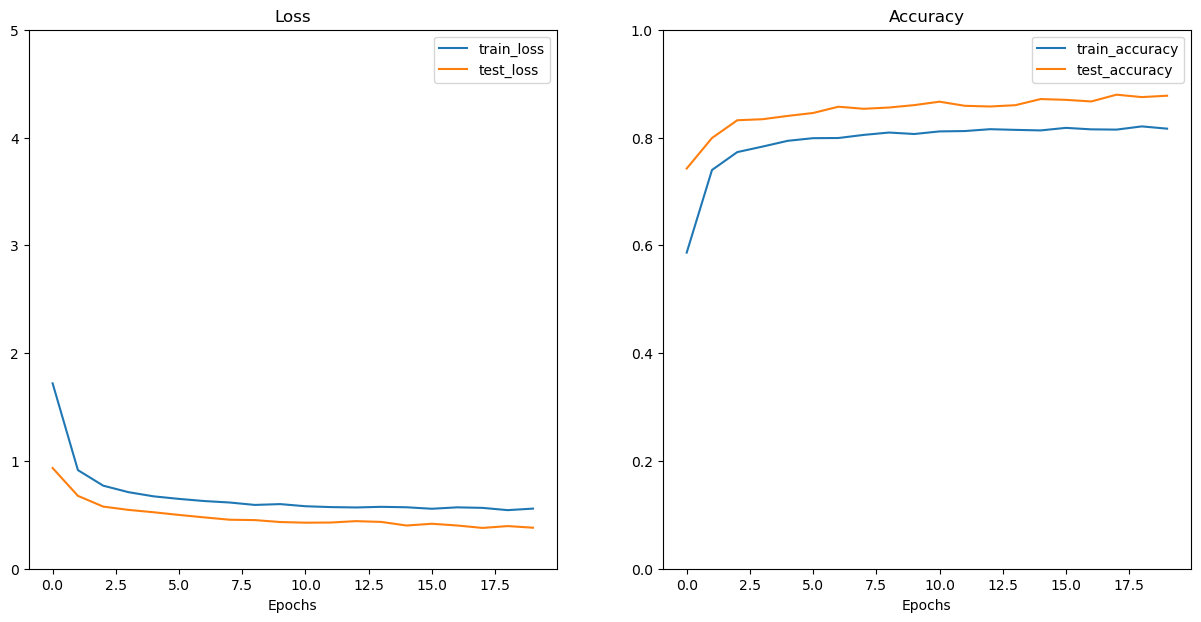

Loss and accuracy curves saved to C:\Data\Python\IFCBclassify_MN\data\models\model_20240706_023737\figures\loss_accuracy_curves.png


In [43]:
# Plot the loss curves and save

#Plot the loss urves of model_1
plot_save_loss_curves(model_1_results, save_path=str(figures_path / 'loss_accuracy_curves.png'))

In [44]:
# # This code cell is for getting this models class specific min and max pixel values from the train directory for use as info in predictions at a later stage.

# # Function to count non-background pixels in a grayscale image
# def count_non_background_pixels_grayscale(image_path, background_color=255):
#     image = Image.open(image_path).convert("L")  # Convert to grayscale
#     image_np = np.array(image)
#     mask = (image_np == background_color)
#     return np.sum(~mask)

# # Determine min and max non-background pixels for each class
# def min_max_pixels_per_class(train_dir):
#     class_pixel_stats = {}
#     for class_folder in os.listdir(train_dir):
#         class_path = os.path.join(train_dir, class_folder)
#         min_pixels = float('inf')
#         max_pixels = 0
#         for image_file in os.listdir(class_path):
#             if image_file.endswith('.png'):
#                 image_path = os.path.join(class_path, image_file)
#                 pixel_count = count_non_background_pixels_grayscale(image_path)
#                 min_pixels = min(min_pixels, pixel_count)
#                 max_pixels = max(max_pixels, pixel_count)
#         class_pixel_stats[class_folder] = {
#             'min': int(min_pixels * 0.8),  # Reduce by 20%
#             'max': int(max_pixels * 1.2)   # Increase by 20%
#         }
#     return class_pixel_stats



In [45]:
from skimage import measure, io, color
import numpy as np
import os
from pathlib import Path

def measure_blob_sizes(image_path):
    """Measure sizes of all blobs in the image."""
    image = io.imread(image_path, as_gray=True)
    # Assume non-background is defined by a threshold, here using Otsu's method
    threshold = skimage.filters.threshold_otsu(image)
    binary = image > threshold
    # Label blobs
    labeled = measure.label(binary)
    # Measure properties of blobs
    properties = measure.regionprops(labeled)
    # Extract the area of each blob
    sizes = [prop.area for prop in properties]
    return sizes

def min_max_blob_sizes_per_class(train_dir):
    class_pixel_stats = {}
    for class_folder in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_folder)
        min_pixels = float('inf')
        max_pixels = 0
        for image_file in os.listdir(class_path):
            if image_file.endswith('.png'):
                image_path = os.path.join(class_path, image_file)
                blob_sizes = measure_blob_sizes(image_path)
                if blob_sizes:  # Ensure there are blobs detected
                    min_pixels = min(min_pixels, min(blob_sizes))
                    max_pixels = max(max_pixels, max(blob_sizes))
        # Adjust the min and max by +/- 20%
        class_pixel_stats[class_folder] = {
            'min': int(min_pixels * 0.8),  # Reduce by 20%
            'max': int(max_pixels * 1.2)   # Increase by 20%
        }
    return class_pixel_stats

# Example usage

class_stats = min_max_blob_sizes_per_class(train_dir)
print(class_stats)

{'Achnathes_like_129': {'min': 0, 'max': 36121}, 'Air_bubbles_149': {'min': 0, 'max': 256004}, 'Akashiwo_sanguinea_057': {'min': 0, 'max': 63028}, 'Alexandrium_pseudogonyaulax_060': {'min': 0, 'max': 25462}, 'Amphidinium_like_015': {'min': 0, 'max': 9586}, 'Apedinella_radians_031': {'min': 0, 'max': 6127}, 'Asterionellopsis_glacialis_034': {'min': 0, 'max': 266548}, 'Beads_148': {'min': 8, 'max': 4471}, 'Centrales_sideview': {'min': 0, 'max': 43447}, 'Centrales_topview': {'min': 0, 'max': 86479}, 'Cerataulina_pelagica_036': {'min': 0, 'max': 132141}, 'Chaetoceroa_affinis_037': {'min': 0, 'max': 373059}, 'Chaetoceros_contortus_128': {'min': 0, 'max': 231632}, 'Chaetoceros_curvicetus_like_151': {'min': 0, 'max': 546018}, 'Chaetoceros_danicus_039': {'min': 0, 'max': 137590}, 'Chaetoceros_debilis_like_152': {'min': 0, 'max': 555856}, 'Chaetoceros_decipiens_118': {'min': 0, 'max': 705828}, 'Chaetoceros_diadema_136': {'min': 0, 'max': 433792}, 'Chaetoceros_didymus_133': {'min': 0, 'max': 133

In [46]:
# Combine the class to idx mapping with blob size info
class_mapping_with_blobs = {}
for class_name, idx in class_to_idx.items():
    class_mapping_with_blobs[class_name] = {
        'id': idx,
        'min_pixels': class_stats.get(class_name, {}).get('min', 0),  # Use default 0 if not found
        'max_pixels': class_stats.get(class_name, {}).get('max', 0)   # Use default 0 if not found
    }

# Save the updated class mapping with blob size info to JSON
class_mapping_path = model_save_path / 'class_mapping.json'
with open(class_mapping_path, 'w') as json_file:
    json.dump(class_mapping_with_blobs, json_file, indent=4)
print(f"Class mapping with blob size information saved to {class_mapping_path}")

Class mapping with blob size information saved to C:\Data\Python\IFCBclassify_MN\data\models\model_20240706_023737\class_mapping.json


In [47]:
# Load the existing class mapping
with open(class_mapping_path, 'r') as f:
    class_mapping = json.load(f)

# Extract class names
class_names = list(class_mapping.keys())

for class_name, attributes in class_mapping.items():
    print(f"Class Name: {class_name}")
    print(f" - ID: {attributes['id']}")
    print(f" - Min Pixels: {attributes['min_pixels']}")
    print(f" - Max Pixels: {attributes['max_pixels']}")
    print("\n")

#class_mapping


Class Name: Achnathes_like_129
 - ID: 0
 - Min Pixels: 0
 - Max Pixels: 36121


Class Name: Air_bubbles_149
 - ID: 1
 - Min Pixels: 0
 - Max Pixels: 256004


Class Name: Akashiwo_sanguinea_057
 - ID: 2
 - Min Pixels: 0
 - Max Pixels: 63028


Class Name: Alexandrium_pseudogonyaulax_060
 - ID: 3
 - Min Pixels: 0
 - Max Pixels: 25462


Class Name: Amphidinium_like_015
 - ID: 4
 - Min Pixels: 0
 - Max Pixels: 9586


Class Name: Apedinella_radians_031
 - ID: 5
 - Min Pixels: 0
 - Max Pixels: 6127


Class Name: Asterionellopsis_glacialis_034
 - ID: 6
 - Min Pixels: 0
 - Max Pixels: 266548


Class Name: Beads_148
 - ID: 7
 - Min Pixels: 8
 - Max Pixels: 4471


Class Name: Centrales_sideview
 - ID: 8
 - Min Pixels: 0
 - Max Pixels: 43447


Class Name: Centrales_topview
 - ID: 9
 - Min Pixels: 0
 - Max Pixels: 86479


Class Name: Cerataulina_pelagica_036
 - ID: 10
 - Min Pixels: 0
 - Max Pixels: 132141


Class Name: Chaetoceroa_affinis_037
 - ID: 11
 - Min Pixels: 0
 - Max Pixels: 373059


Clas

In [48]:

# Example data to save into CSV
model_name = 'ResNet18'
model_description = 'ResNet18 model with custom final layer'
epochs = 20
optimizer_used = 'Adam'
learning_rate = initial_lr

# Example training results (replace with actual values from your training)
train_loss = model_1_results['train_loss']
train_accuracy = model_1_results['train_acc']
test_loss = model_1_results['test_loss']
test_accuracy = model_1_results['test_acc']

# Combine data into dictionaries
model_data = {
    'Model Name': [model_name],
    'Model Description': [model_description],
    'Epochs': [epochs],
    'Optimizer': [optimizer_used],
    'Learning Rate': [learning_rate]
}

epochs_data = {
    'Epoch': range(1, epochs + 1),
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy
}

# Create DataFrames
df_model_info = pd.DataFrame(model_data)
df_epoch_results = pd.DataFrame(epochs_data)

# Concatenate DataFrames
df_combined = pd.concat([df_model_info, df_epoch_results], axis=1)

# Save to CSV
csv_file = model_save_path / 'model_info.csv'
df_combined.to_csv(csv_file, index=False)
print(f"Model information and epoch results saved to {csv_file}")

Model information and epoch results saved to C:\Data\Python\IFCBclassify_MN\data\models\model_20240706_023737\model_info.csv


C:\Users\nma\AppData\Local\Temp\ipykernel_26508\68589022.py:20: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  filled_labeled_global = morphology.remove_small_holes(labeled_global, area_threshold=500)


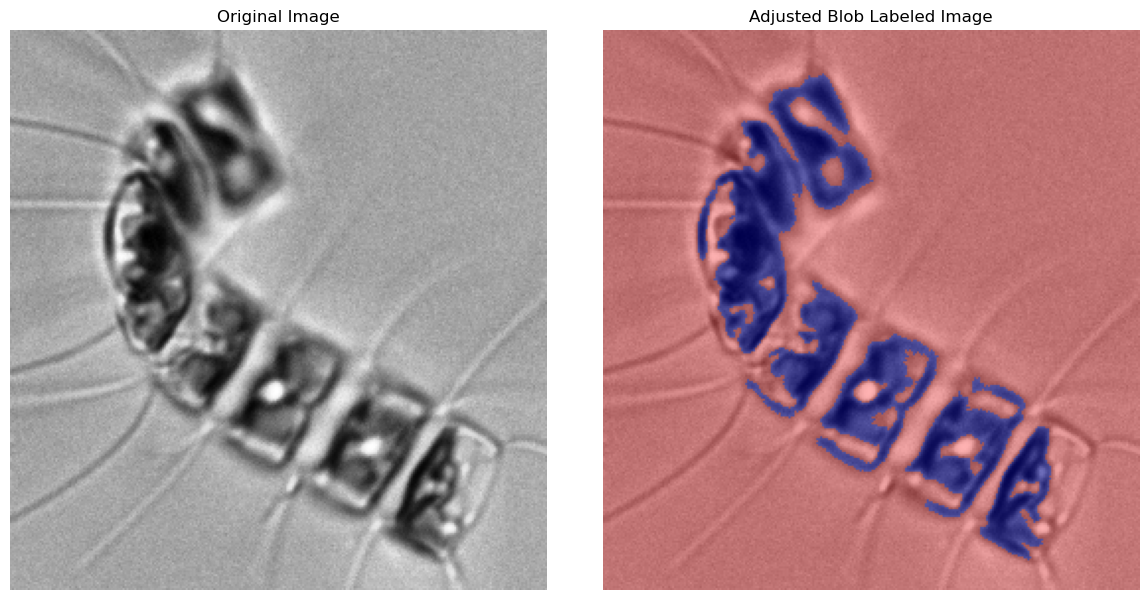

In [79]:
#Code for possible later updates to blob measurement:
import matplotlib.pyplot as plt
from skimage import measure, io, color, filters, morphology, exposure
import numpy as np

def visualize_and_adjust_blobs(image_path):
    """Visualize and adjust blob detection parameters."""
    image = io.imread(image_path, as_gray=True)
    
    # Enhance contrast to improve blob detection
    image = exposure.equalize_adapthist(image)
    
    # Global thresholding
    global_thresh = filters.threshold_otsu(image)
    binary_global = image > global_thresh
    
    # Label blobs with 8-connectivity
    labeled_global = measure.label(binary_global, connectivity=2)
    
    # Fill holes within blobs
    filled_labeled_global = morphology.remove_small_holes(labeled_global, area_threshold=500)
    
    # Optionally remove small objects
    labeled_global = morphology.remove_small_objects(filled_labeled_global, min_size=20)  # Adjust `min_size` as needed
    
    # Display the images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    labeled_img = color.label2rgb(labeled_global, image=image, bg_label=0, bg_color=(0, 0, 1))
    ax[1].imshow(labeled_img)
    ax[1].set_title('Adjusted Blob Labeled Image')
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()


# Example usage
image_path = "C:/Data/Python/IFCB/data/D20230315T000054_IFCB139_00042.png"  # Update this path to an actual image file
visualize_and_adjust_blobs(image_path)